In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate

import mission_tools

%matplotlib widget

In [2]:
# load the offshore wave conditon dataframe
offshore_df = pd.read_csv('../microSWIFT_data/mission_df.csv')
mission_19_df = offshore_df[offshore_df['mission number'] == 19]
mission_19_df

,Unnamed: 0,time,mission number,Hs [m],Tm [s],Mean Dir [deg],cross shore gamma location [m],break depth,freq [hz],energy density [m^2\hz],direction bins [deg],directional energy density [m^2/hz/deg],wind speed [m/s],wind direction [deg],water level [m]
6,6,2021-10-08 18:31:59.996640,19,1.153885,5.855787,67.689864,273.300564,3.296814,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.01377242289597856, 0.05397805134639883, 0.2...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[2.326480534975417e-05, 2.5262941562687047e-0...",8.237333,33.15201,-0.399


In [3]:
# Get list of all missions
mission_nums = offshore_df["mission number"].unique()

# Set the breaking threshold from the breaker dataset
breaking_threshold = 2

breaking_x_tracks = []
breaking_y_tracks = []
nonbreaking_x_tracks = []
nonbreaking_y_tracks = []

for mission_num in mission_nums:
    # Load mission 19 data and plot tracks over the radar image
    mission_nc_path = f'../microSWIFT_data/final_dataset/mission_{mission_num}.nc'
    mission_dataset = nc.Dataset(mission_nc_path, mode='r')

    # Compute Stokes Drift Estimate from offshore conditions
    mission_df = offshore_df[offshore_df['mission number'] == mission_num]
    g = 9.8 
    Tm = mission_df['Tm [s]'].values[0]
    Hs = mission_df['Hs [m]'].values[0]
    stokes_drift = (((2 * np.pi)**3 / g) * Hs**2 / Tm**3)

    # Solve for Offshore Wavelength
    lambda_m = 1 / mission_tools.solve_dispersion_relation(9.8, 8, 2*np.pi/Tm)

    # Split trajectories from mission 19 into bins
    window_size_seconds = int(Tm)
    window_size = window_size_seconds * 12
    time = np.linspace(0, window_size_seconds, num=window_size)

    x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
    y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
    vertical_accels = np.ma.masked_invalid(mission_dataset['acceleration_z_body'])
    time_vals = mission_dataset['time'][:]

    num_microswifts = x_locations.shape[0]
    for microswift_num in range(num_microswifts):
        x_location_individual = x_locations[microswift_num,:]
        x_location_windowed = np.reshape(x_location_individual[:(x_location_individual.size//window_size * window_size)],
                                    (x_location_individual.size//window_size, window_size))

        y_location_individual = y_locations[microswift_num,:]
        y_location_windowed = np.reshape(y_location_individual[:(y_location_individual.size//window_size * window_size)],
                                    (y_location_individual.size//window_size, window_size))
        
        vertical_accel_individual = vertical_accels[microswift_num,:]
        vertical_accel_windowed = np.reshape(vertical_accel_individual[:(vertical_accel_individual.size//window_size * window_size)],
                                    (vertical_accel_individual.size//window_size, window_size))

        # Compute Baseline variance to compare the breaking variance to 
        vertical_accel_total_variance = np.nanvar(vertical_accel_individual)
        vertical_accel_var_in_window = np.nanvar(vertical_accel_windowed, axis=1)
        
        # Number of windows 
        num_windows = x_location_windowed.shape[0]

        # Get breaking events in each segment
        for n in range(num_windows):
            try:
                # checking if breaking occurs in the window
                breaking_in_segment = vertical_accel_var_in_window[n] > (breaking_threshold*vertical_accel_total_variance)

                if breaking_in_segment:
                    breaking_x_tracks.append(x_location_windowed[n,:])
                    breaking_y_tracks.append(y_location_windowed[n,:])
                
                else:
                    nonbreaking_x_tracks.append(x_location_windowed[n,:])
                    nonbreaking_y_tracks.append(y_location_windowed[n,:])
            except:
                continue



In [9]:
print(len(breaking_x_tracks))
print(len(nonbreaking_y_tracks))

4915
166222


In [4]:
def distance_formula(x, y):
    """
    Compute the distance between the start x and y location and each other location
    """
    return np.sqrt((x[0]-x)**2 + (y[0]-y)**2)

ValueError: x and y must have same first dimension, but have shapes (132,) and (72,)

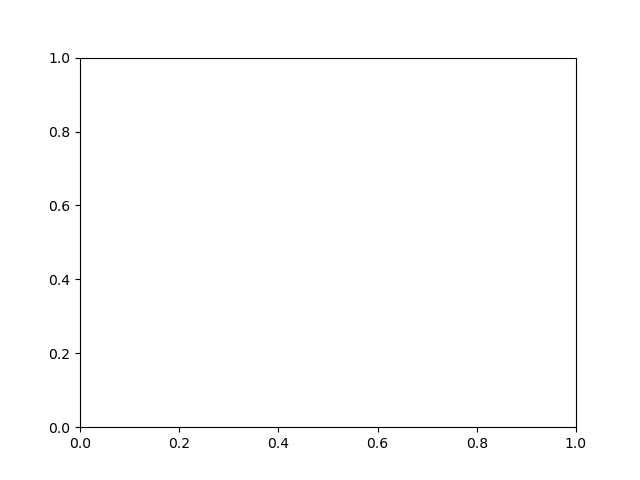

In [5]:
fig, ax = plt.subplots()
for n in range(len(nonbreaking_x_tracks)-1):
    ax.plot(time/Tm, distance_formula(nonbreaking_x_tracks[n], nonbreaking_y_tracks[n])/lambda_m, color='gray', alpha=0.5)
ax.plot(time/Tm, distance_formula(nonbreaking_x_tracks[-1], nonbreaking_y_tracks[-1])/lambda_m, color='gray', label='Tracks without Breaking Events', alpha=0.5)

for n in range(len(breaking_x_tracks)-1):
    ax.plot(time/Tm, distance_formula(breaking_x_tracks[n], breaking_y_tracks[n])/lambda_m, color='blue', alpha=0.5)
ax.plot(time/Tm, distance_formula(breaking_x_tracks[-1], breaking_y_tracks[-1])/lambda_m, color='blue', label='Tracks with Breaking Events', alpha=0.5)

# Stokes Drift Estimate
ax.plot(time/Tm, (stokes_drift * (time/Tm))/lambda_m, color='r', label='Stokes Drift Estimate')

ax.set_xlabel('Normalized Time (t/$T_m)$')
ax.set_ylabel('Normalized Distance (x/$\lambda_m$)')
ax.legend()

/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


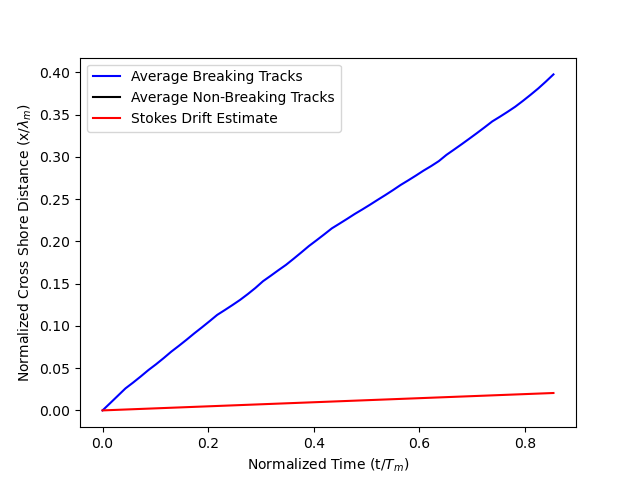

In [ ]:
# Average the normalized breaking and nonbreaking tracks
breaking_tracks_norm = np.empty((len(breaking_x_tracks), time.size))
for n in range(breaking_tracks_norm.shape[0]):
    breaking_tracks_norm[n,:] = (distance_formula(breaking_x_tracks[n].filled(np.nan), breaking_y_tracks[n].filled(np.nan))/lambda_m)

nonbreaking_tracks_norm = np.empty((len(nonbreaking_x_tracks), time.size))
for n in range(breaking_tracks_norm.shape[0]):
    nonbreaking_tracks_norm[n,:] = (distance_formula(nonbreaking_x_tracks[n].filled(np.nan), nonbreaking_y_tracks[n].filled(np.nan))/lambda_m)
time_norm = time/Tm

# Average Tracks
breaking_tracks_norm_avg = np.nanmean(breaking_tracks_norm, axis=0)
nonbreaking_tracks_norm_avg = np.nanmean(nonbreaking_tracks_norm, axis=0)

# Track standard deviation
breaking_tracks_norm_std = np.nanstd(breaking_tracks_norm, axis=0)
nonbreaking_tracks_norm_std = np.nanstd(nonbreaking_tracks_norm, axis=0)

fig, ax = plt.subplots()
ax.plot(time_norm, breaking_tracks_norm_avg, color='blue', label='Average Breaking Tracks')

ax.plot(time_norm, nonbreaking_tracks_norm_avg, color='k', label='Average Non-Breaking Tracks')

ax.plot(time/Tm, (stokes_drift * (time/Tm))/lambda_m, color='r', label='Stokes Drift Estimate')
ax.set_xlabel('Normalized Time (t/$T_m)$')
ax.set_ylabel('Normalized Cross Shore Distance (x/$\lambda_m$)')
ax.legend()

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_44353/534338589.py:8: RuntimeWarning: invalid value encountered in add
  ax.plot(time_norm, nonbreaking_tracks_norm_avg+nonbreaking_tracks_norm_std, color='k', alpha=0.5, linestyle='dashed')


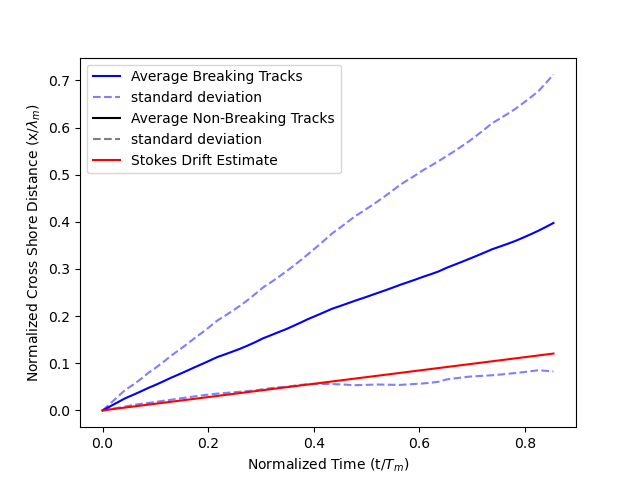

In [26]:
fig, ax = plt.subplots()
ax.plot(time_norm, breaking_tracks_norm_avg, color='blue', label='Average Breaking Tracks')
ax.plot(time_norm, breaking_tracks_norm_avg-breaking_tracks_norm_std, color='blue', alpha=0.5, linestyle='dashed')
ax.plot(time_norm, breaking_tracks_norm_avg+breaking_tracks_norm_std, color='blue', alpha=0.5, linestyle='dashed', label='standard deviation')

ax.plot(time_norm, nonbreaking_tracks_norm_avg, color='k', label='Average Non-Breaking Tracks')
ax.plot(time_norm, nonbreaking_tracks_norm_avg-nonbreaking_tracks_norm_std, color='k', alpha=0.5, linestyle='dashed', label='standard deviation')
ax.plot(time_norm, nonbreaking_tracks_norm_avg+nonbreaking_tracks_norm_std, color='k', alpha=0.5, linestyle='dashed')

ax.plot(time/Tm, (stokes_drift * (time))/lambda_m, color='r', label='Stokes Drift Estimate')
ax.set_xlabel('Normalized Time (t/$T_m)$')
ax.set_ylabel('Normalized Cross Shore Distance (x/$\lambda_m$)')
ax.legend()